In [5]:
# Helper packages
library(tidyverse)
library(rsample) # for data splitting
# Modeling packages
library(earth) # for fitting MARS models
library(caret) # for automating the tuning process

library(vip) # for variable importance
library(pdp) # for variable relationships

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v purrr   0.3.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

Warning message:
"package 'tibble' was built under R version 4.0.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
x purrr::lift()    masks caret::lift()
x purrr::partial() masks pdp::partial()



In [6]:
ames <- read_csv('data/ames.csv')
set.seed(123)
split <- initial_split(ames, prop = 0.7,
strata = "Sale_Price")
ames_train <- training(split)
ames_test <- testing(split)

Parsed with column specification:
cols(
  .default = col_character(),
  Lot_Frontage = col_double(),
  Lot_Area = col_double(),
  Year_Built = col_double(),
  Year_Remod_Add = col_double(),
  Mas_Vnr_Area = col_double(),
  BsmtFin_SF_1 = col_double(),
  BsmtFin_SF_2 = col_double(),
  Bsmt_Unf_SF = col_double(),
  Total_Bsmt_SF = col_double(),
  First_Flr_SF = col_double(),
  Second_Flr_SF = col_double(),
  Low_Qual_Fin_SF = col_double(),
  Gr_Liv_Area = col_double(),
  Bsmt_Full_Bath = col_double(),
  Bsmt_Half_Bath = col_double(),
  Full_Bath = col_double(),
  Half_Bath = col_double(),
  Bedroom_AbvGr = col_double(),
  Kitchen_AbvGr = col_double(),
  TotRms_AbvGrd = col_double()
  # ... with 15 more columns
)

See spec(...) for full column specifications.



In [7]:
# Fit a basic MARS model
mars1 <- earth(
Sale_Price ~ .,
data = ames_train
)
# Print model summary
print(mars1)

Selected 36 of 40 terms, and 28 of 291 predictors
Termination condition: RSq changed by less than 0.001 at 40 terms
Importance: Gr_Liv_Area, Year_Built, Total_Bsmt_SF, Overall_QualExcellent, ...
Number of terms at each degree of interaction: 1 35 (additive model)
GCV 547654257    RSS 1.047912e+12    GRSq 0.9150216    RSq 0.9207205


The vertical dashed lined at 36 tells us
the optimal number of non-intercept terms retained where marginal increases
in GCV 𝑅2 are less than 0.001.

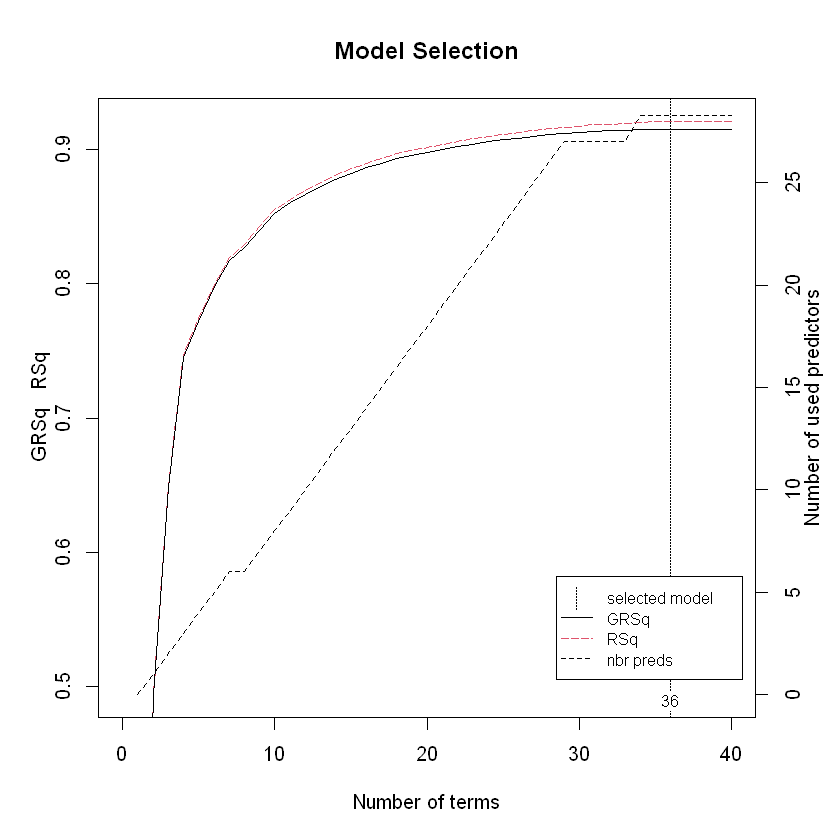

In [9]:
plot(mars1, which=1)

In [10]:
# Include interaction effects: use degree = 2

# Fit a basic MARS model
mars2 <- earth(
Sale_Price ~ .,
data = ames_train, 
    degree = 2)

# check out the first 10 coefficient terms
summary(mars2) %>% .$coefficients %>% head(10)


,Sale_Price
(Intercept),2.540927e+05
h(Gr_Liv_Area-2787),-1.593725e+02
h(2787-Gr_Liv_Area),-4.979191e+01
h(Year_Built-2004),4.378076e+03
h(2004-Year_Built),-6.146599e+02
h(Total_Bsmt_SF-1298),8.598767e+01
h(1298-Total_Bsmt_SF),-4.217897e+01
h(Bsmt_Unf_SF-1017)*h(2787-Gr_Liv_Area),-2.371253e-02
h(1017-Bsmt_Unf_SF)*h(2787-Gr_Liv_Area),1.069393e-02
Condition_1Norm*h(Gr_Liv_Area-2787),2.906994e+02


There are two important tuning parameters associated with our MARS model:
the maximum degree of interactions and the number of terms retained in
the final model.

we set up a grid that assesses 30 different combinations
of interaction complexity (degree) and the number of terms to retain
in the final model (nprune).

In [11]:
# create a tuning grid
hyper_grid <- expand.grid(
degree = 1:3,
nprune = seq(2, 100, length.out = 10) %>% floor()
)
head(hyper_grid)

,degree,nprune
,<int>,<dbl>
1,1,2
2,2,2
3,3,2
4,1,12
5,2,12
6,3,12


In [16]:
# Cross-validated model
set.seed(123) # for reproducibility
cv_mars <- train(
x = subset(ames_train, select = -Sale_Price),
y = ames_train$Sale_Price,
method = 'earth',
metric = 'RMSE',
trControl = trainControl(method = 'cv', number = 10),
tuneGrid = hyper_grid
)
# View results
cv_mars$bestTune
## nprune degree
## 25 45 3
ggplot(cv_mars)

Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"predictions failed for Fold01: degree=1, nprune=100 Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels
"
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"predictions failed for Fold01: degree=2, nprune=100 Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels
"
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"predictions failed for Fold01: degree=3, nprune=100 Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels
"
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"predictions failed for Fold02: degree=1, nprune=100 Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + i

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


Something is wrong; all the RMSE metric values are missing:
      RMSE        Rsquared        MAE     
 Min.   : NA   Min.   : NA   Min.   : NA  
 1st Qu.: NA   1st Qu.: NA   1st Qu.: NA  
 Median : NA   Median : NA   Median : NA  
 Mean   :NaN   Mean   :NaN   Mean   :NaN  
 3rd Qu.: NA   3rd Qu.: NA   3rd Qu.: NA  
 Max.   : NA   Max.   : NA   Max.   : NA  
 NA's   :30    NA's   :30    NA's   :30   


ERROR: Error: Stopping


In [15]:
cv_mars

ERROR: Error in eval(expr, envir, enclos): object 'cv_mars' not found


In [14]:
# variable importance plots
p1 <- vip(cv_mars, num_features = 40, bar = FALSE, value = 'gcv') +
ggtitle('GCV')

p2 <- vip(cv_mars, num_features = 40, bar = FALSE, value = 'rss') +
ggtitle('RSS')

gridExtra::grid.arrange(p1, p2, ncol = 2)

ERROR: Error in vip(cv_mars, num_features = 40, bar = FALSE, value = "gcv"): object 'cv_mars' not found


In [ ]:
# extract coefficients, convert to tidy data frame, and
# filter for interaction terms
cv_mars$finalModel %>%
coef() %>%
broom::tidy() %>%
filter(stringr::str_detect(names, ”\\*”))

In [13]:
# Construct partial dependence plots
p1 <- partial(cv_mars, pred.var = 'Gr_Liv_Area') %>% autoplot()
p2 <- partial(cv_mars, pred.var = 'Year_Built') %>% autoplot()
p3 <- partial(cv_mars, pred.var = c('Gr_Liv_Area', 'Year_Built'),
chull = TRUE) %>%
plotPartial(palette = 'inferno', contour = TRUE) %>%
ggplotify::as.grob() # convert to grob to plot with cowplot
# Display plots in a grid
top_row <- cowplot::plot_grid(p1, p2)
cowplot::plot_grid(top_row, p3, nrow = 2, rel_heights = c(1, 2))

ERROR: Error in partial(cv_mars, pred.var = "Gr_Liv_Area"): object 'cv_mars' not found
